## **Install packages**

In [1]:
%%capture
!pip install datasets
!pip install gensim
!pip install sentence-transformers
!pip install contractions
!pip install nltk
!pip install scikit-learn
!python -m spacy download en_core_web_md
!pip install transformers tensorflow


## **Import liabraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import contractions
import time
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/'

import spacy

from transformers import BertTokenizer, TFBertModel
from sentence_transformers import util
from torch.utils.data import DataLoader
import torch
from gensim.models.fasttext import FastText
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.plotting import plot_confusion_matrix
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import xgboost as xgb
import string
import joblib
import re
import os
import shutil
import math




Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Loading dataset**

In [3]:
from datasets import load_dataset
import pandas as pd


# Load the Quora dataset from Hugging Face
dataset_train = load_dataset('glue', 'mrpc', split='train')
dataset_test=load_dataset('glue', 'mrpc', split='test')

# Convert the dataset to a pandas DataFrame
df_train = dataset_test.to_pandas()
df_test = dataset_test.to_pandas()






/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [9]:
df_train.head()


,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1,0
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1,2
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0,3
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0,4


In [7]:
df_test.head()


,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1,0
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1,2
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0,3
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0,4


In [10]:
df_train

,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1,0
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1,2
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0,3
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0,4
...,...,...,...,...
1720,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0,1720
1721,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0,1721
1722,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0,1722
1723,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1,1723


In [12]:
df_test

,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1,0
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1,2
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0,3
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0,4
...,...,...,...,...
1720,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0,1720
1721,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0,1721
1722,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0,1722
1723,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1,1723


## **Data Analysis**


Exploratory data analysis is the process of analyzing and summarizing a dataset to gain insights and understanding of its main characteristics. It involves techniques such as data visualization, summary statistics, and data cleaning to discover patterns and relationships within the data. EDA is a crucial step in the data analysis process as it helps to inform subsequent modeling and analysis decisions.



<Axes: xlabel='label'>

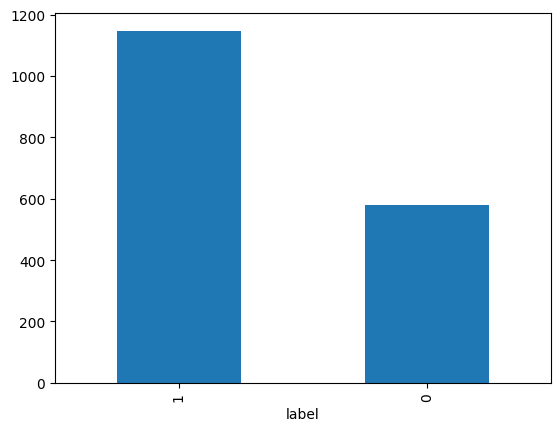

In [13]:
df_train['label'].value_counts().plot(kind='bar')

<Axes: xlabel='label'>

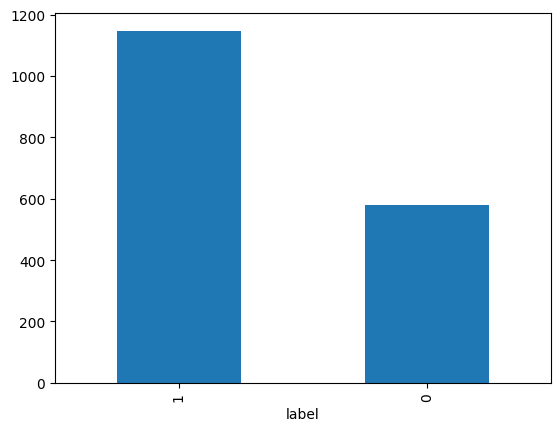

In [14]:
df_test['label'].value_counts().plot(kind='bar')


In [4]:
# Repeated question in train dataset
qid = pd.Series(df_train['sentence1'].tolist() + df_train['sentence2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 3393
Number of questions getting repeated 55


In [5]:
# Repeated question in test dataset
qid = pd.Series(df_test['sentence1'].tolist() + df_test['sentence2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 3393
Number of questions getting repeated 55


## **Feature Engineering**

Let us now construct a few features like:

freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [11]:
#Feature engineering
df = df_train
df['freq_qid1'] = df.groupby('sentence1')['sentence2'].transform('count')
df['freq_qid2'] = df.groupby('sentence2')['sentence2'].transform('count')
df['q1len'] = df['sentence1'].str.len()
df['q2len'] = df['sentence2'].str.len()
df['q1_words'] = df['sentence1'].apply(lambda x: len(x.split(" ")))
df['q2_words'] = df['sentence2'].apply(lambda x: len(x.split(" ")))

def normalized_word_count(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))
    return 1.0 * (len(w1 & w2))
df['word_common'] = df.apply(normalized_word_count, axis = 1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



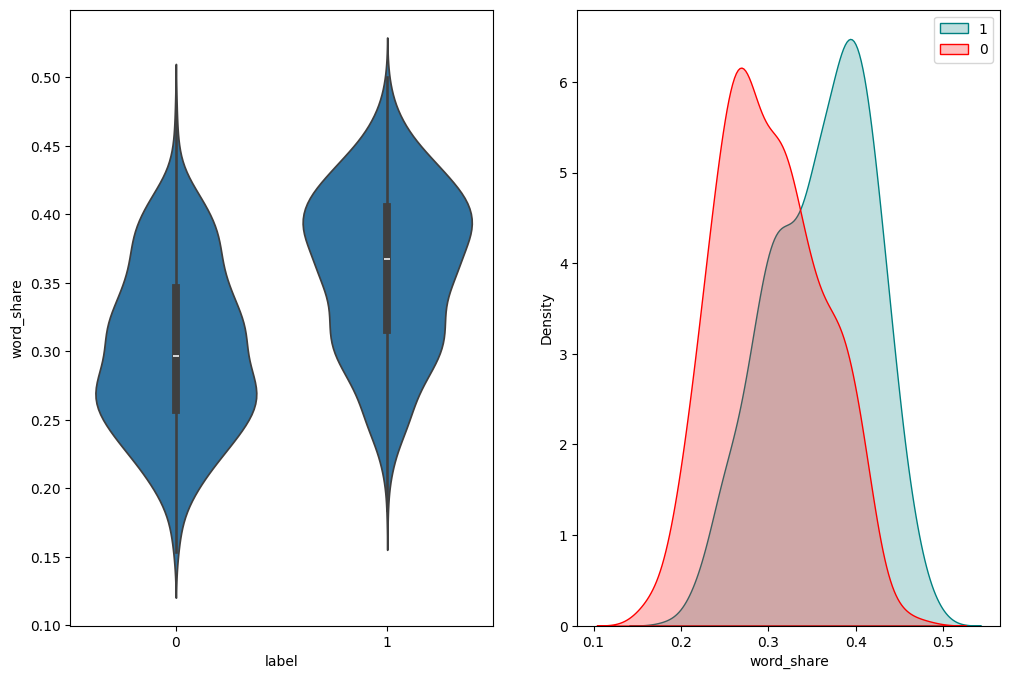

In [12]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "label", y = "word_share", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['label'] == 1]['word_share'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['label'] == 0]['word_share'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

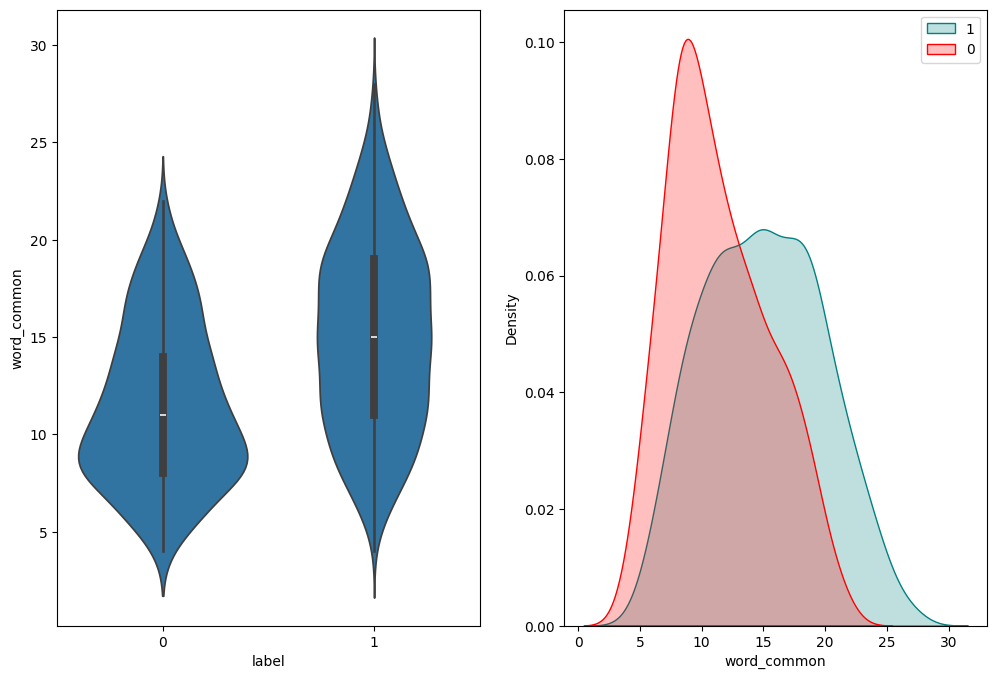

In [13]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "label", y = "word_common", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['label'] == 1]['word_common'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['label'] == 0]['word_common'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

Both of the plots presented in the analysis suggest that there is significant overlap between the distributions of the word_Common feature in similar and non-similar questions. This means that the word_Common feature alone may not be a strong enough indicator to determine whether two questions are similar or not. It is important to take into account other features as well when building models for identifying duplicate questions, in order to achieve a high level of accuracy.

## **Pre-processing of data**

In [8]:
#Pre-processing of data
def preprocess_data(text):
    # convert to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())

    return text

Applying pre-process data to train data

In [9]:
df_preprocess_train = df_train.copy() # Create a copy of the original dataframe

#change the name to df_train_preprocess
df_preprocess_train.loc[:,"sentence1"] = df_preprocess_train["sentence2"].apply(preprocess_data)
df_preprocess_train.loc[:,"sentence1"] = df_preprocess_train["sentence2"].apply(preprocess_data)
df_preprocess_train.head()

,sentence1,sentence2,label,idx
0,current chief operating officer mike butcher a...,Current Chief Operating Officer Mike Butcher a...,1,0
1,domestic sales at both gm and no ford motor co...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,the centers for disease control and prevention...,The Centers for Disease Control and Prevention...,1,2
3,tropical storm rapidly developed in the gulf o...,A tropical storm rapidly developed in the Gulf...,0,3
4,but company officials expect the costs of the ...,But company officials expect the costs of the ...,0,4


Applying pre-process data to test data

In [18]:
df_preprocess_test = df_test.copy() # Create a copy of the original dataframe
df_preprocess_test.loc[:,"sentence1"] = df_preprocess_test["sentence2"].apply(preprocess_data)
df_preprocess_test.loc[:,"sentence1"] = df_preprocess_test["sentence2"].apply(preprocess_data)
df_preprocess_test.head()



,sentence1,sentence2,label,idx
0,current chief operating officer mike butcher a...,Current Chief Operating Officer Mike Butcher a...,1,0
1,domestic sales at both gm and no ford motor co...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,the centers for disease control and prevention...,The Centers for Disease Control and Prevention...,1,2
3,tropical storm rapidly developed in the gulf o...,A tropical storm rapidly developed in the Gulf...,0,3
4,but company officials expect the costs of the ...,But company officials expect the costs of the ...,0,4


### **TF-IDF Vectorizer**

In [20]:
# Fit Tfidf Vectorizer of train & test dataset

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_preprocess_train['sentence1']+' '+df_preprocess_train['sentence2'])

#no. of feature
test_tfidf = tfidf.transform(df_preprocess_test['sentence1']+' '+df_preprocess_test['sentence2'])

train_tfidf.shape,test_tfidf.shape

((1725, 7523), (1725, 7523))

### **XGBclassification**

In [28]:

labels = df_preprocess_train['label']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_tfidf,labels)

predictions_train=model_xgb.predict(train_tfidf)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(df_preprocess_train['label'],predictions_train))
print("Classification Report:\n", classification_report(df_preprocess_train['label'],predictions_train))

predictions_test = model_xgb.predict(test_tfidf)
predictions_test = list(predictions_test)




print('Test Accuracy score:',accuracy_score(df_preprocess_test['label'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['label'],predictions_test))

Train Accuracy score: 0.9518840579710145
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       578
           1       0.94      0.99      0.96      1147

    accuracy                           0.95      1725
   macro avg       0.96      0.93      0.94      1725
weighted avg       0.95      0.95      0.95      1725

Test Accuracy score: 0.9518840579710145
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       578
           1       0.94      0.99      0.96      1147

    accuracy                           0.95      1725
   macro avg       0.96      0.93      0.94      1725
weighted avg       0.95      0.95      0.95      1725



##**LightGBM Classifier**

In [29]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_tfidf,labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(train_tfidf)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

predictions_test = model_xgb.predict(test_tfidf)
predictions_test = list(predictions_test)

print('Test Accuracy score:',accuracy_score(df_preprocess_test['label'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['label'],predictions_test))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4473
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Train Accuracy score: 0.9565217391304348
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93       578
           1       0.95      0.99      0.97      1147

    accuracy                           0.96      1725
   macro avg       0.96      0.94      0.95      1725
weighted avg       0.96      0.96      0.96      1725

Test Accuracy score: 0.9518840579710145
Classification 

## **Word2Vec**

## Word2Vec using word tokenization on train data

In [30]:
# Assuming 'processed_questions' contains preprocessed text
X = df_preprocess_train[['sentence1', 'sentence2']]
y = df_preprocess_train['label']

# Tokenize the sentences
tokenized_sentences_q1 = X['sentence1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['sentence2'].apply(lambda x: str(x).split())

In [31]:
# Train Word2Vec model
word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences_q1, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model_q1) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model_q2) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_combined = np.concatenate((X_q1, X_q2), axis=1)

labels = df_preprocess_train['label']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_train=model_xgb.predict(X_combined)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(df_preprocess_train['label'],predictions_train))
print("Classification Report:\n", classification_report(df_preprocess_train['label'],predictions_train))



Train Accuracy score: 0.9965217391304347
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [32]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Train Accuracy score: 0.9965217391304347
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



## Word2Vec using word tokenization on test data

In [33]:

# Assuming 'processed_questions' contains preprocessed text
X = df_preprocess_test[['sentence1', 'sentence2']]
y = df_preprocess_test['label']

# Tokenize the sentences
tokenized_sentences_q1 = X['sentence1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['sentence2'].apply(lambda x: str(x).split())



In [34]:
# Train Word2Vec model
word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences_q1, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model_q1) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model_q2) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_combined = np.concatenate((X_q1, X_q2), axis=1)


labels = df_preprocess_test['label']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_test=model_xgb.predict(X_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(df_preprocess_test['label'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['label'],predictions_test))


Test Accuracy score: 0.9965217391304347
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [35]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

predictions_test=model_lgb.predict(X_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(df_preprocess_test['label'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['label'],predictions_test))


[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Test Accuracy score: 0.9959420289855072
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



## **SBERT**

In [36]:
#Load pre-trained model
model_name = 'paraphrase-distilroberta-base-v2'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## **SBERT applied on sample train data**

In [37]:

sampled_df = df_train

# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['sentence1'].tolist())
question2_embeddings = model.encode(sampled_df['sentence2'].tolist())


X_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['label'].values


model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_train=model_xgb.predict(X_combined)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['label'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['label'],predictions_train))


Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [38]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



## **SBERT applied on sample test data**

In [39]:

sampled_df = df_test
#sampled_df=new_df_train


# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['sentence1'].tolist())
question2_embeddings = model.encode(sampled_df['sentence2'].tolist())


X_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['label'].values


model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_test=model_xgb.predict(X_combined)
print('Test Accuracy score:',accuracy_score(sampled_df['label'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['label'],predictions_test))

Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [ ]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_test = model_lgb.predict(X_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

[LightGBM] [Info] Number of positive: 1100, number of negative: 1900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366667 -> initscore=-0.546544
[LightGBM] [Info] Start training from score -0.546544
Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1900
        True       1.00      1.00      1.00      1100

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



##**GloVe**

###  Load SpaCy  for tokenization

In [40]:
nlp = spacy.load("en_core_web_md")

### Load GloVe embeddings

In [41]:



def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_embeddings = load_glove_embeddings('/content/drive/My Drive/glove.6B.100d.txt')

### **Function to embed questions using SpaCy tokenization and GloVe on train data**

In [43]:
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)


sampled_df = df_preprocess_train
# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    # Preprocess the data and create embeddings for each question pair
embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['sentence1'], nlp)
    q2_embedding = embed_question(row['sentence2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    embeddings.append(combined_embedding)
    labels.append(row['label'])

In [44]:


model_xgb = xgb.XGBClassifier()
model_xgb.fit(embeddings,labels)


predictions_train=model_xgb.predict(embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['label'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['label'],predictions_train))

Train Accuracy score: 0.9965217391304347
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [45]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(embeddings,labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Train Accuracy score: 0.9965217391304347
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



### Function to embed questions using SpaCy and GloVe on test data

In [46]:

# Function to embed questions using SpaCy and GloVe
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)

sample_size = 1000  # Adjust as needed
sampled_df = df_preprocess_test.sample(n=sample_size, random_state=42)
# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    # Preprocess the data and create embeddings for each question pair
embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['sentence1'], nlp)
    q2_embedding = embed_question(row['sentence2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    embeddings.append(combined_embedding)
    labels.append(row['label'])

In [47]:

model_xgb = xgb.XGBClassifier()
model_xgb.fit(embeddings,labels)


predictions_test=model_xgb.predict(embeddings)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(sampled_df['label'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['label'],predictions_test))

Test Accuracy score: 0.998
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       332
           1       1.00      1.00      1.00       668

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(embeddings,labels)


predictions_test=model_xgb.predict(embeddings)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_test))

[LightGBM] [Info] Number of positive: 347, number of negative: 653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347000 -> initscore=-0.632252
[LightGBM] [Info] Start training from score -0.632252
Test Accuracy score: 0.995
Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       653
        True       1.00      0.99      0.99       347

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



## **BERT**

## **Load BERT Model**

In [48]:

# Load pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

## **Implement BERT on train dataset**

In [51]:

sampled_df = df_train


# Tokenize questions using BERT tokenizer
question1_tokens = tokenizer(sampled_df['sentence1'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
question2_tokens = tokenizer(sampled_df['sentence2'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)

# Define batch size
batch_size = 8

# Encode questions using BERT model with reduced batch size
question1_embeddings = []
question2_embeddings = []

for i in range(0, len(sampled_df), batch_size):
    batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
    batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

    # Encode questions using BERT model
    batch_question1_embeddings = roberta_model(batch_question1_tokens)['pooler_output']
    batch_question2_embeddings = roberta_model(batch_question2_tokens)['pooler_output']

    question1_embeddings.append(batch_question1_embeddings)
    question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = tf.concat(question1_embeddings, axis=0)
question2_embeddings = tf.concat(question2_embeddings, axis=0)
X_combined = tf.concat([question1_embeddings, question2_embeddings], axis=1).numpy()

# Generate labels for the sampled data

# Generate labels for the sampled data
labels = sampled_df['label'].values

# Train Gradient Boosting Classifier

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [52]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



## **Implement BERT Model on test dataset**

In [53]:

sampled_df = df_test


# Tokenize questions using BERT tokenizer
question1_tokens = tokenizer(sampled_df['sentence1'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
question2_tokens = tokenizer(sampled_df['sentence2'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)

# Define batch size
batch_size = 8

# Encode questions using BERT model with reduced batch size
question1_embeddings = []
question2_embeddings = []

for i in range(0, len(sampled_df), batch_size):
    batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
    batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

    # Encode questions using BERT model
    batch_question1_embeddings = roberta_model(batch_question1_tokens)['pooler_output']
    batch_question2_embeddings = roberta_model(batch_question2_tokens)['pooler_output']

    question1_embeddings.append(batch_question1_embeddings)
    question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = tf.concat(question1_embeddings, axis=0)
question2_embeddings = tf.concat(question2_embeddings, axis=0)
X_combined = tf.concat([question1_embeddings, question2_embeddings], axis=1).numpy()

# Generate labels for the sampled data

# Generate labels for the sampled data
labels = sampled_df['label'].values

# Train Gradient Boosting Classifier

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_test = model_xgb.predict(X_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725



In [54]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_test = model_lgb.predict(X_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

[LightGBM] [Info] Number of positive: 1147, number of negative: 578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.664928 -> initscore=0.685331
[LightGBM] [Info] Start training from score 0.685331
Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      1725
   macro avg       1.00      1.00      1.00      1725
weighted avg       1.00      1.00      1.00      1725

